In [1]:
# pip install geopy

In [2]:
from geopy import geocoders
from geopy.geocoders import Nominatim
import config

In [3]:
# conda install geopandas

In [4]:
# conda install bokeh

In [5]:
import geopandas as gpd

In [6]:
states_map = gpd.read_file('cb_2018_us_state_20m/cb_2018_us_state_20m.shp')
states_map.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


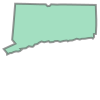

In [7]:
states_map.iloc[34]['geometry']

#### Get State Lead Level Means from SQL

In [8]:
import mysql.connector
import config
import pandas as pd

In [9]:
#set up mysql connection
cnx = mysql.connector.connect(
   host = config.host,
   user = config.user,
   password = config.password)
cursor = cnx.cursor()

In [10]:
#specify database for connection
cnx = mysql.connector.connect(
   host = config.host,
   user = config.user,
   password = config.password,
   database = "water")
cursor = cnx.cursor()

In [11]:
cursor.execute("""SELECT State, AVG(DetectedLevel)
                        FROM water.water_tablefinal
                        WHERE water_tablefinal.Contaminant = 'Lead'
                        GROUP BY State
                        ;""")
leaddf = pd.DataFrame(cursor.fetchall())
leaddf.columns = [x[0] for x in cursor.description]
leaddf.head()

,State,AVG(DetectedLevel)
0,Alaska,0.564133
1,Arkansas,0.279875
2,Arizona,4.987475
3,California,0.303833
4,Colorado,7.830829


In [12]:
missingstates = pd.DataFrame({"State":['Washington', 'Michigan', 'Mississippi',
                                      'Kentucky', 'Indiana', 'Alabama', 'Vermont',
                                      'Maine', 'Rhode Island'],
                             "AVG(DetectedLevel)":[0,0,0,0,0,0,0,0,0]})
missingstates.head()

,State,AVG(DetectedLevel)
0,Washington,0
1,Michigan,0
2,Mississippi,0
3,Kentucky,0
4,Indiana,0


In [13]:
leaddf = leaddf.append(missingstates, ignore_index=True)
leaddf

,State,AVG(DetectedLevel)
0,Alaska,0.564133
1,Arkansas,0.279875
2,Arizona,4.987475
3,California,0.303833
4,Colorado,7.830829
5,Connecticut,0.200440
6,Massachusetts,0.377378
7,Florida,7.611111
8,Georgia,9.703740
9,Iowa,0.311571


In [14]:
leaddf = leaddf.rename(columns={'State':'NAME', 'AVG(DetectedLevel)':'AVGLeadLevel'})

In [15]:
leadbystate = states_map.merge(leaddf, left_on = 'NAME', right_on = 'NAME')

In [16]:
leadbystate = leadbystate.loc[~leadbystate['NAME'].isin(['Alaska','Hawaii'])]

In [17]:
leadbystate.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,AVGLeadLevel
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",0.323455
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",0.311571
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",3.651657
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",1.330000
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",2.378467


#### Mapping

In [18]:
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource, 
                         CustomJS, CustomJSFilter, GeoJSONDataSource,
                         HoverTool, LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure

#input GeoJSON source for plotting
geosource = GeoJSONDataSource(geojson = leadbystate.to_json())

In [19]:
# #create figure object
# p = figure(title = 'Average Level Levels in Water from 2014-2019',
#            plot_height = 600,
#            plot_width = 950,
#            toolbar_location = 'below',
#            tools = 'pan, wheel_zoom, box_zoom, reset')
# p.xgrid.grid_line_color = None
# p.ygrid.grid_line_color = None

# #add patch renderer to figure
# states = p.patches('xs','ys', source = geosource,
#                   fill_color=None, line_color='gray',
#                   line_width=0.25, fill_alpha = 1)

# #create hover tool
# p.add_tools(HoverTool(renderers=[states],
#                      tooltips=[('State','@NAME'),
#                                ('Avg. Lead Level', '@AVGLeadLevel')]))
# show(p)

In [20]:
#define color palettes
palette = brewer['Oranges'][9]
palette = palette[::-1]

color_mapper = LinearColorMapper(palette = palette, low = 0, high = 15)

tick_labels = {'0':'0',
              '0.1':'0.1',
                '1':'1',
               '2':'2',
               '4':'4',
               '6':'6',
               '9':'9',
               '12':'12',
               '15':'15+',
              }

color_bar = ColorBar(color_mapper = color_mapper,
                    label_standoff = 8, width = 500,
                    height = 20, border_line_color = None,
                    location = (0,0),
                    orientation = 'horizontal',
                    major_label_overrides = tick_labels)


p = figure(title = 'Average Lead Levels in Water from 2018',
           plot_height = 600,
           plot_width = 950,
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#add patch renderer to figure
states = p.patches('xs','ys', source = geosource,
                  fill_color= {'field': 'AVGLeadLevel', 
                               'transform': color_mapper},
                   line_color='gray',
                  line_width=0.25, fill_alpha = 1)

#create hover tool
p.add_tools(HoverTool(renderers=[states],
                     tooltips=[('State','@NAME'),
                               ('Avg. Lead Level', '@AVGLeadLevel')]))
show(p)